# Calculo das variáveis aleatórias
Temos que no código abaixo possui a implementação das seguintes distribuições: <br>
- Distribuição normal;
- Distribuição log-normal;
- Gumbel para máximos e Gumbel para mínimos <br>

No código abaixo, temos uma estrutura de _data members_, na qual é possível calcular os momentos da distribuição (média, variância, desvio-padrão, coeficiente de variação, skewness e kurtosis) dado os parâmetros. <br>
Além disso, há uma estrutura de _member functions_ que calcula as funções $PDF$, $CDF$ e $CDF^{-1}$ e também calcula os parâmetros dados os momentos.


In [2]:
from scipy import stats as st 
import numpy as np
import matplotlib.pyplot as plt

# Data members
class variavel_aleatoria:
    # Função para identificar qual é a distribuição, o nome da variável e o simbolo da distribuição
    def __init__(self, distribuicao: str, nome: str = "", simbolo: str =""):
        # Identificação
        self.nome = nome
        self.simbolo = simbolo
        self.distribuicao = distribuicao  

        # Lista de argumentos
        self.parametros = []
        self.objeto = None

        # Momentos da variável
        self.media = np.nan 
        self.variancia = np.nan
        self.desvio = np.nan
        self.cv = np.nan # Coeficiente de variação
        self.skewness = np.nan
        self.kurtosis = np.nan

        # Distribuições implementadas
        self.distribuicoes = {
            'normal' : st.norm,
            'lognormal' : st.lognorm,
            'gumbel_max': st.gumbel_r,
            'gumbel_min': st.gumbel_l,
            'uniforme': st.uniform
        }

        # Aqui as distribuições contempladas são atribuidas ao componente objeto
        self.objeto = self.distribuicoes[self.distribuicao]

        # Aqui os parâmetros de cada distribuição são definidos e os momentos calculados a partir dos parâmetros
    def conjunto_parametros (self, *params):
        self.parametros = list(params)
        self.calculo_momentos()
    
        # Aqui os momentos são calculados a partir dos parametros
    def calculo_momentos(self):
        m, v, sk, k = self.objeto.stats(*self.parametros, moments = 'mvsk')

        # Armazenamento dos momentos nas variáveis
        self.media = float(m)
        self.variancia = float(v)
        self.desvio = np.sqrt(self.variancia)
        self.skewness = float(sk)
        self.kurtosis = float(k)

        if self.distribuicao == 'uniforme':
            loc = self.parametros[0]
            scale = self.parametros[1]

            a = loc
            b = loc + scale

            self.media = (a + b) / 2.0
            self.variancia = (scale ** 2) / 12
            self.desvio = np.sqrt(self.variancia) 
            self.skewness = 0.0
            self.kurtosis = 1.8

        if self.media != 0:
            self.cv = self.desvio / self.media
        else:
            self.cv = np.nan

    # Aqui calcula-se os parametros de cada distribuição dado os momentos (média e desvio padrão)
    def calculo_parametros (self, media_dada: float, desvio_dado: float):
        mu = media_dada
        sigma = desvio_dado

        if self.distribuicao =='normal':
            self.conjunto_parametros(mu, sigma)
        
        elif self.distribuicao == 'lognormal':
            zeta = np.sqrt(np.log(1.0 + (sigma / mu) ** 2))
            lam = np.log(mu) - (0.5 * (zeta ** 2))
            scale = np.exp(lam)
            self.conjunto_parametros(zeta, 0.0, scale)
        
        elif self.distribuicao == 'uniforme':
            scale = desvio_dado * np.sqrt(12)
            loc = media_dada - (scale / 2.0)
            self.calculo_parametros(loc, scale)

        elif self.distribuicao in ['gumbel_max', 'gumbel_min']:
            mu = media_dada
            sigma = desvio_dado
            gamma = 0.5772156649 #Constante de Euler
            beta = (sigma * np.sqrt(6)) / np.pi 

            if self.distribuicao == 'gumbel_max':
                mu_calc = mu - (gamma * beta)
            else:
                mu_calc = mu + (gamma * beta)
            self.conjunto_parametros(mu_calc, beta)
    
    # Agora vamos construir as funções fundamentais (PDF, CDF, Inversa)
    def PDF (self, x: float) -> float:
        if self.objeto:
            return self.objeto.pdf(x, *self.parametros)
        return np.nan
    
    def CDF (self, x: float) -> float:
        if self.objeto:
            return self.objeto.cdf(x, *self.parametros)
        return np.nan
    
    def InversaCDF (self, p: float) -> float:
        if self.objeto:
            return self.objeto.ppf(p, *self.parametros)
        return np.nan

# Plot das distribuições
Para a tensão média p' temos a seguinte distribuição


In [3]:
#Teste da estrutura
effective_mean_stress = variavel_aleatoria(distribuicao = 'normal', nome='VA lognormal', simbolo='X_LN')
media_dada = 527.822
sigma_dado = 381.481
effective_mean_stress.conjunto_parametros(media_dada, sigma_dado)

# Teste do conjunto de parametros e momentos para uma distribuição normal
print('Verificação da distribuição normal: Calculo dos momentos dados os parâmetros')
print(f"X: {effective_mean_stress.nome}")
print(f"Parâmetros: {effective_mean_stress.parametros}")
print(f"Média calculada: {effective_mean_stress.media}")
print(f"Desvio padrão: {effective_mean_stress.desvio}")
print(f"Coeficiente de variação: {effective_mean_stress.cv}")
print(f"Skewness: {effective_mean_stress.skewness}")
print(f"Kurtosis: {effective_mean_stress.kurtosis}")

Verificação da distribuição normal: Calculo dos momentos dados os parâmetros
X: VA lognormal
Parâmetros: [527.822, 381.481]
Média calculada: 527.822
Desvio padrão: 381.481
Coeficiente de variação: 0.7227455467941843
Skewness: 0.0
Kurtosis: 0.0


Uma vez calculados os parâmetros, agora vamos vamos plotar os resultados $x_{aprox} = CDF^{-1}(x,CDF(X,x))$ para um intervalo $\mu - 3\sigma \leq x \leq \mu + 3\sigma$ e também vamos plotar a função $PDF$ para a tensão efetia média.

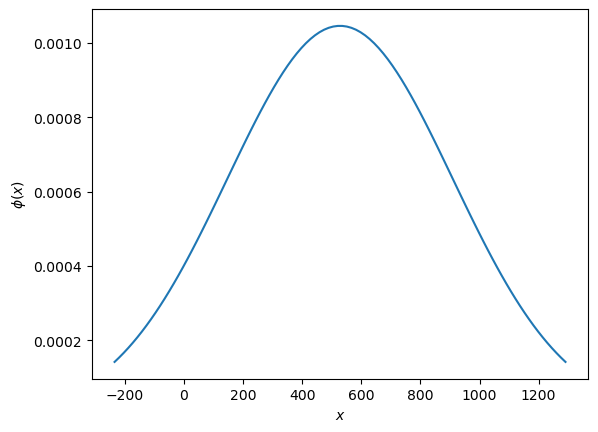

In [17]:
import matplotlib.pyplot as plt


x_min = media_dada - (2 * sigma_dado)
x_max = media_dada + (2 * sigma_dado)
x_real = np.linspace(x_min, x_max, 100)

'''
x_min = 0.001
x_max = 0.999
x_min_plot = effective_mean_stress.InversaCDF(x_min)
x_max_plot = effective_mean_stress.InversaCDF(x_max)
x_real = np.linspace(x_min_plot, x_max_plot, 100)
'''

x_aproximado = []
pdf = []
for x in x_real:
    p = effective_mean_stress.CDF(x)
    pdf_calc = effective_mean_stress.PDF(x)
    x_calc = effective_mean_stress.InversaCDF(p)
    x_aproximado.append(x_calc)
    pdf.append(pdf_calc)

# Plotar função PDF
plt.plot(x_real, pdf)
plt.xlabel('$x$')
plt.ylabel('$\\phi(x)$')
plt.show()

Agora vamos plotar a distribuição relativa ao indice de vazios


In [ ]:
#Teste da estrutura
X_lognormal = variavel_aleatoria(distribuicao = 'lognormal', nome='VA lognormal', simbolo='X_LN')
zeta_dado = 0.2
lamb_dado = 5
X_lognormal.conjunto_parametros(zeta_dado, 0, float(np.exp(lamb_dado)))

# Teste do conjunto de parametros e momentos para uma distribuição normal
print('Verificação da distribuição lognormal: Calculo dos momentos dados os parâmetros')
print(f"X: {X_lognormal.nome}")
print(f"Parâmetros: {lamb_dado, zeta_dado}")
print(f"Média calculada: {X_lognormal.media}")
print(f"Desvio padrão: {X_lognormal.desvio}")
print(f"Coeficiente de variação: {X_lognormal.cv}")
print(f"Skewness: {X_lognormal.skewness}")
print(f"Kurtosis: {X_lognormal.kurtosis}")

Uma vez calculados os parâmetros, agora vamos vamos plotar os resultados $x_{aprox} = CDF^{-1}(x,CDF(X,x))$ e também vamos plotar a função $PDF$.

In [ ]:
import matplotlib.pyplot as plt

x_min = 0.001
x_max = 0.999
x_min_plot = X_lognormal.InversaCDF(x_min)
x_max_plot = X_lognormal.InversaCDF(x_max)
x_real = np.linspace(x_min_plot, x_max_plot, 100)

x_aproximado = []
pdf = []
for x in x_real:
    p = X_lognormal.CDF(x)
    pdf_calc = X_lognormal.PDF(x)
    x_calc = X_lognormal.InversaCDF(p)
    x_aproximado.append(x_calc)
    pdf.append(pdf_calc)

# Gráfico do valor aproximado x valor real
plt.plot(x_real, x_aproximado, 'r')
plt.xlabel('$x_{real}$')
plt.ylabel('$x_{aproximado}$')
plt.show()

# Plotar função PDF
plt.plot(x_real, pdf)
plt.xlabel('$x$')
plt.ylabel('$\\phi(x)$')
plt.show()

# Algoritmo de mapeamento
Temos que o código abaixo faz o caclulo da matriz de correlação $R_z$ utilizando a distribuição de Nataf e calcula os Jacobianos $J_{yz}$ e $J_{zy}$ da tranformação $(Z -> Y)$ tanto utilizando a decomposição de Cholesky quanto a decomposição ortogonal.

In [6]:
import numpy as np
from UQpy.transformations import Nataf
from UQpy.distributions import Normal as uqpynormal
from UQpy.distributions import Lognormal as uqpylognormal
from UQpy.distributions import Uniform as uqpyuniform
from UQpy.distributions.collection import GeneralizedExtreme as uqpygev  

# Função de mapeamento para o uso do UQpy que retorna os parametros de cada distribuição
def mapeamento_uqpy(va_cust):
    tipo = va_cust.distribuicao.lower()
    parametros = va_cust.parametros

    if tipo == 'normal':
        return uqpynormal(loc=parametros[0], scale=parametros[1])

    elif tipo == 'lognormal':
        return uqpylognormal(s=parametros[0], loc=parametros[1], scale=parametros[2])
    
    elif tipo in ['gumbel_max', 'gumbel_min']:
        shape_c = 0.0
        loc = parametros[0]   
        scale = parametros[1] 
        return uqpygev(c=shape_c, loc=loc, scale=scale)
    
    elif tipo == 'uniforme':
        loc = parametros[0]
        scale = parametros[1]
        return uqpyuniform(loc=loc, scale=scale)
    
    else:
        raise ValueError(f"Distribuição '{tipo}' não mapeada")
        
# Data members
class vetores_variavel_aleatoria:
    matriz_observações: np.ndarray # Cada linha é uma variável aleatória X_i e cada coluna uma observação
    vetor_va_cust: list
    matriz_correlacao_x: np.ndarray # Matriz de correlação
    matriz_correlacao_z: np.ndarray = None

    # Função de recebimento do vetor
    def __init__(self, matriz_observacoes: np.ndarray, vetor_va_cust: list):
        
        self.matriz_observações = matriz_observacoes
        self.vetor_va_cust = vetor_va_cust
        self.calc_matriz_correlacao()

    # Determinação da dimensão do vetor de variáveis aleatórias
    def dimensao (self) -> tuple:
        return np.shape(self.vetor_va_cust)
    
    # Calculo da matriz de correlação Rx
    def calc_matriz_correlacao(self):
        self.matriz_correlacao_x = np.corrcoef(self.matriz_observações)
        return self.matriz_correlacao_x

    # Calculo da matriz de correlação no espaço normal padrão (Rz) 
    def matriz_correlacao_nataf(self) -> np.ndarray:
        distribuicoes_uqpy = [mapeamento_uqpy(va) for va in self.vetor_va_cust]
        
        nataf_obj = Nataf(distributions=distribuicoes_uqpy, corr_x=self.matriz_correlacao_x)
        
        Rz = nataf_obj.corr_z # Matriz de corelação zij
        self.matriz_correlacao_z = Rz
        
        return Rz
    
    # Matriz de eliminação da correlação via decomposição de Cholesky e calculo dos Jacobianos Z -> Y
    def decomposicao_cholesky(self) -> np.ndarray:
        B = np.linalg.cholesky(self.matriz_correlacao_z)
        
        L = np.linalg.inv(B.T)
        Jyz = np.linalg.inv(L) # Jacobiano Jyz
        Jzy = L # Jacobiano Jzy

        return Jyz, Jzy
    
    # Matriz de eliminação da correlação via decomposição de decomposição ortogonal e calculo dos Jacobianos Z -> Y
    def descorrelacao_autovetores(self) -> np.ndarray:
        Rz = self.matriz_correlacao_z

        # W é o vetor de autovalores
        # A_barra é a matriz onde cada coluna é um autovetor de Rz 
        W, A_barra = np.linalg.eigh(Rz) 

        # Construção da diagonal da matriz inversa dos auto-valores
        Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(W))

        # Matriz de descorrelação A
        A = A_barra @ Lambda_inv_sqrt

        # Jacobiano Jyz
        Jyz = A.T

        # Jacobiano Jzy
        Jzy = np.linalg.inv(A.T)

        return Jyz, Jzy

# Tarefa T4
Para resolução da tarefa 4 vamos resolver o Exemplo 4 apresentado no livro. Para isso implementamos o algoritmo FORM completo, o qual se reduz ao algoritmo FOSM uma vez que todas as variáveis possuem distribuição normal. Para essa resolução, o ponto $y_{k+1}$ foi calculado de acordo com a Equação 3.33 apresentada no livro, sem a implementação do algortimo HLRF. 
$$
y_{k+1}=-\alpha_k[\Beta_{k} + \frac{g(y_k)}{||\nabla g(y_k)||}]
$$
Como critério de parada, utilizou-se:
$$
1 - |\frac{\nabla g(y_{k+1})y_{k+1}}{||\nabla g(y_{k+1})|| ||y_{k+1}||}| < \epsilon \\
$$
$$
|g(y_{k+1})| < \delta
$$

In [19]:
import numpy as np
import scipy as sc
import sympy as sp
from sympy.utilities.lambdify import lambdify
from typing import Callable, List, Tuple

class Ponto_projeto:
    def __init__(self, vx_obj, g_fun_numerica_x, calculo_g_y, g_sym_fun, vetor_simbolico, x_inicial, max_iter=100):

        # Inicialização das variáveis
        self.vx_obj = vx_obj 
        self.g_fun_x_num = g_fun_numerica_x
        self.g_y_num = calculo_g_y
        self.grad_g_x_fun = self.calcular_gradiente_simbolico_x(g_sym_fun, vetor_simbolico)
        self.x_estrela_atual = x_inicial
        self.max_iter = max_iter
        self.historico = []

    # Atualização das matrizes de média e desvio padrão equivalente
    def normal_equivalente_no_ponto (self, vetor_x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

        mu_neq_lista = []
        sigma_neq_lista = []

        for i, va in enumerate(self.vx_obj.vetor_va_cust):
            x_i = vetor_x[i]

            cdf_xi = va.CDF(x_i)
            pdf_xi = va.PDF(x_i)

            z_i = sc.stats.norm.ppf(cdf_xi)
            phi_zi = sc.stats.norm.pdf(z_i)

            sigma_neq_i = phi_zi / pdf_xi
            mu_neq_i = x_i - (z_i * sigma_neq_i)

            mu_neq_lista.append(mu_neq_i)
            sigma_neq_lista.append(sigma_neq_i)

        return np.array(mu_neq_lista), np.diag(sigma_neq_lista)
    
    # Calculo do gradiente numérico da função g(x) a partir da função simbólica fornecida paara g(x)
    def calcular_gradiente_simbolico_x(self, g_sym:sp.Expr, vetor_simbolico: List[sp.Symbol]) -> Callable:
        
        grad_g_sym = [sp.diff(g_sym, x_i) for x_i in vetor_simbolico]

        grad_g_numeric = lambdify(vetor_simbolico, grad_g_sym, 'numpy')
        
        def grad_g_x_numerico(x_vals: np.ndarray) -> np.ndarray:
            return np.array(grad_g_numeric(*x_vals))
        
        return grad_g_x_numerico
     
    # Estrutura principal de calculo e iteração em busca do ponto de projeto
    def execution (self,):

        historico = [] # Vetor que armazena o histórico de iterações

        for k in range(self.max_iter):
            
            # Ponto de projeto x* para a iteração k
            x_k = self.x_estrela_atual 

            # Atualização das matrizes de média e desvio padrão equivalentes para o ponto x_k
            # Calculo dos Jacobianos da transformação X -> Z
            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            # Trandformação do ponto xk -> yk
            y_k = J_yx @ (x_k - mu_neq)

            # Calculo do índice de confiabilidade para o ponto yk
            beta_k = np.linalg.norm(y_k)
            
            # Avaliação das funções g(x) em x_k e g(y) em y_k
            g_x = self.g_fun_x_num(x_k)
            g_y = self.g_y_num(y_k)

            if k == 0:
                g_y_zero = g_y

            # Calculo do gradiente de g(x) no espaço de projeto X em x_k
            grad_g_x = self.grad_g_x_fun(x_k)

            # Calculo do gradiente de g(y) em y_k a partir da transformação X -> Y
            grad_g_y = (J_xy.T) @ grad_g_x

            # Calculo dos coeficientes de sensibilidade
            alpha = grad_g_y / np.linalg.norm(grad_g_y)

            historico.append([
                k, 
                y_k, 
                beta_k, 
                g_x, 
                grad_g_y, 
                np.linalg.norm(grad_g_y)
            ])  

            # Calculo do ponto de projeto y_k+1
            #y_k_mais_1 = (((1 / np.linalg.norm(grad_g_y)) ** 2) * (((grad_g_y.T) @ y_k) - g_y)) * grad_g_y # Algoritmo HLRF
            y_k_mais_1 = - alpha * (beta_k + ((g_y) / np.linalg.norm(grad_g_y)))
            
            # Calculo do ponto x_k+1 a partir da tranformação Y -> X
            x_k_mais_1 = (J_xy @ y_k_mais_1) + mu_neq

            # Verificação da convergência do ponto y_k+1
            ep = 1e-3    
            g_x_mais_1 = self.g_fun_x_num(x_k_mais_1)
            grad_x_mais_1 = self.grad_g_x_fun(x_k_mais_1)
            g_y_mais_1 = self.g_y_num(y_k_mais_1)
            grad_y_mais_1 = (J_xy.T) @ grad_x_mais_1
            verificador = 1 - (abs((grad_y_mais_1.T @ y_k_mais_1) / ((np.linalg.norm(grad_y_mais_1)) * (np.linalg.norm(y_k_mais_1)))))
            
            if verificador < ep:
                if abs(np.linalg.norm(g_y_mais_1)) < (ep * g_y_zero):

                    historico.append([
                        k+1, 
                        y_k_mais_1, 
                        np.linalg.norm(y_k_mais_1), 
                        g_x_mais_1, 
                        grad_y_mais_1, 
                        np.linalg.norm(grad_y_mais_1)
                    ])  
                    break
                else:
                    self.x_estrela_atual = x_k_mais_1 
            else:
                self.x_estrela_atual = x_k_mais_1

                if k == self.max_iter - 1:
                    print(f"Não convergiu em {self.max_iter} iterações")
    
        return historico

Tentativa de utilização do FOSM

In [ ]:
from math import log
import numpy as np
import sympy as sp
import pandas as pd

# Construção do vetor de médias e desvio padrão
D = np.array([
    [0.081, 0],
    [0, 381.481]
])

medias = np.array([0.856, 527.822])

# Equação do estado limite g(X)
X1,X2 = sp.symbols('X1 X2')
vetor_simbolico_x = [X1, X2]
g_sym_function = X1 - (1.242 - (0.053 * np.log(X2)))

def g_fun_numerica(x: np.ndarray) -> float:

    return x[0] - (1.242 - (0.053 * np.log(x[1])))

# Transformação X -> Y da equação de estado-limite g(X)
Y1,e,P,L = sp.symbols('Y1 e P L')
vetor_simbolico_y = [Y1, P]
def g_y_simbolico_fun (vetor_x_simbolico):
    e = 0.05
    L = 1
    return (L / 4) - e - (vetor_x_simbolico[1] * (vetor_x_simbolico[0] - ((vetor_x_simbolico[0]**2) / L)))

# Equação do estado limite g(X)
X1, X2, X3 = sp.symbols('X1 X2')
vetor_simbolico_x = [X1, X2, X3]
g_sym_function = (X1 * X2) - X3

def g_fun_numerica(x: np.ndarray) -> float:
    # x é um vetor [X1, X2, X3]
    return (x[0] * x[1]) - x[2]

# Transformação X -> Y da equação de estado-limite g(X)
Y1, Y2, Y3 = sp.symbols('Y1 Y2 Y3')
vetor_simbolico_y = [Y1, Y2, Y3]

vetor_simbolico_x_calc = (D @ vetor_simbolico_y) + medias

g_y_simbolico = (vetor_simbolico_x_calc[0] * vetor_simbolico_x_calc[1]) - vetor_simbolico_x_calc[2]
g_y_numerico = lambdify(vetor_simbolico_y, g_y_simbolico, 'numpy')

def calculo_g_y(vetor_y):
     
     return g_y_numerico(vetor_y[0], vetor_y[1], vetor_y[2])

# Descrição das variáveis aleatórias 
X1 = variavel_aleatoria(distribuicao='normal', nome='sigma_y', simbolo='X1')
X1.conjunto_parametros(40.0, 5.0) 

X2 = variavel_aleatoria(distribuicao='normal', nome='W', simbolo='X2')
X2.conjunto_parametros(50.0, 2.5) 

X3 = variavel_aleatoria(distribuicao='normal', nome='M', simbolo='X3')
X3.conjunto_parametros(1000.0, 200.0)

vetor_va = [X1, X2, X3]

# Montagem das matrizes de observações e correlações
# RX deve ser a matriz identidade (Independentes)
matriz_dummy_obs = np.zeros((3, 3)) # Matriz das observações para iniciar o algoritmo
Rx_entrada = np.eye(3) # Matriz Identidade (Não há correlação)

# 4. Inicializar VX (T3)
vx_obj = vetores_variavel_aleatoria(matriz_dummy_obs, vetor_va)
vx_obj.matriz_correlacao_x = Rx_entrada
Rz = vx_obj.matriz_correlacao_nataf() # Garante que Cz é calculado (Cz = Rx = I)
J_yz, J_zy = vx_obj.decomposicao_cholesky()


# Ponto inicial (ponto médio)
x_start = medias
ponto_projeto_obj = Ponto_projeto(vx_obj, g_fun_numerica, calculo_g_y, g_sym_function, vetor_simbolico_x, x_start, max_iter=200)

# Resultado da iteração
resultado_iteração = ponto_projeto_obj.execution()
dados_arredondados = [[np.round(x, 3) for x in linha] for linha in resultado_iteração]

# Montagem da tabela
tabela = pd.DataFrame(dados_arredondados, columns=['k', 'y', 'B', 'g(x)', 'grad_g(y)', '||grad_g(y)||' ])
tabela

# Busca do pronto de projeto

No código abaixo, a busca pelo ponto $y_{k+1}$ é realizada utilizando a implementação do algoritmo *HLRF*

In [4]:
import numpy as np
import scipy as sc
import sympy as sp
from sympy.utilities.lambdify import lambdify
from typing import Callable, List, Tuple

class Ponto_projeto_HRLF:
    def __init__(self, vx_obj, g_fun_numerica_x, vetor_simbolico_y, g_y_simbolico, g_sym_fun, vetor_simbolico, x_inicial, max_iter=100):

        # Inicialização das variáveis
        self.vx_obj = vx_obj 
        self.g_fun_x_num = g_fun_numerica_x
        self.vetor_simbolico_y = vetor_simbolico_y
        self.g_y_simbolico = g_y_simbolico
        self.grad_g_x_fun = self.calcular_gradiente_simbolico_x(g_sym_fun, vetor_simbolico)
        self.x_estrela_atual = x_inicial
        self.max_iter = max_iter
        self.historico = []

    # Atualização das matrizes de média e desvio padrão equivalente
    def normal_equivalente_no_ponto (self, vetor_x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

        mu_neq_lista = []
        sigma_neq_lista = []

        for i, va in enumerate(self.vx_obj.vetor_va_cust):
            x_i = vetor_x[i]

            cdf_xi = va.CDF(x_i)
            pdf_xi = va.PDF(x_i)

            z_i = sc.stats.norm.ppf(cdf_xi)
            phi_zi = sc.stats.norm.pdf(z_i)

            sigma_neq_i = phi_zi / pdf_xi
            mu_neq_i = x_i - (z_i * sigma_neq_i)

            mu_neq_lista.append(mu_neq_i)
            sigma_neq_lista.append(sigma_neq_i)

        return np.array(mu_neq_lista), np.diag(sigma_neq_lista)
    
    # Calculo do gradiente numérico da função g(x) a partir da função simbólica fornecida paara g(x)
    def calcular_gradiente_simbolico_x(self, g_sym:sp.Expr, vetor_simbolico: List[sp.Symbol]) -> Callable:
        
        grad_g_sym = [sp.diff(g_sym, x_i) for x_i in vetor_simbolico]

        grad_g_numeric = lambdify(vetor_simbolico, grad_g_sym, 'numpy')
        
        def grad_g_x_numerico(x_vals: np.ndarray) -> np.ndarray:
            return np.array(grad_g_numeric(*x_vals))
        
        return grad_g_x_numerico
     
    # Estrutura principal de calculo e iteração em busca do ponto de projeto
    def execution (self,):

        historico = [] # Vetor que armazena o histórico de iterações

        for k in range(self.max_iter):
            
            # Ponto de projeto x* para a iteração k
            x_k = self.x_estrela_atual 

            # Atualização das matrizes de média e desvio padrão equivalentes para o ponto x_k
            # Calculo dos Jacobianos da transformação X -> Z
            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            vetor_simbolico_y = self.vetor_simbolico_y
            vetor_simbolico_x_calc = (J_xy @ vetor_simbolico_y) + mu_neq
            g_y_simbolico = self.g_y_simbolico(vetor_simbolico_x_calc)
            g_y_numerico = lambdify(vetor_simbolico_y, g_y_simbolico, 'numpy')
            
            def calculo_g_y(vetor_y):
                return g_y_numerico(*vetor_y)
            
            # Trandformação do ponto xk -> yk
            y_k = J_yx @ (x_k - mu_neq)

            # Calculo do índice de confiabilidade para o ponto yk
            beta_k = np.linalg.norm(y_k)
            
            # Avaliação das funções g(x) em x_k e g(y) em y_k
            g_x = self.g_fun_x_num(x_k)
            g_y = calculo_g_y(y_k)

            if k == 0:
                g_y_zero = g_y

            # Calculo do gradiente de g(x) no espaço de projeto X em x_k
            grad_g_x = self.grad_g_x_fun(x_k)

            # Calculo do gradiente de g(y) em y_k a partir da transformação X -> Y
            grad_g_y = (J_xy.T) @ grad_g_x

            # Calculo dos coeficientes de sensibilidade
            alpha = grad_g_y / np.linalg.norm(grad_g_y)

            historico.append([
                k, 
                y_k, 
                beta_k, 
                g_x, 
                grad_g_y, 
                np.linalg.norm(grad_g_y),
                g_y,
                x_k
            ])  

            # Calculo do ponto de projeto y_k+1
            y_k_mais_1 = (((1 / np.linalg.norm(grad_g_y)) ** 2) * (((grad_g_y.T) @ y_k) - g_y)) * grad_g_y # Algoritmo HLRF
            #y_k_mais_1 = - alpha * (beta_k + ((g_y) / np.linalg.norm(grad_g_y)))
            
            # Calculo do ponto x_k+1 a partir da tranformação Y -> X
            x_k_mais_1 = (J_xy @ y_k_mais_1) + mu_neq

            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k_mais_1)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            vetor_simbolico_y = self.vetor_simbolico_y
            vetor_simbolico_x_calc = (J_xy @ vetor_simbolico_y) + mu_neq
            g_y_simbolico = self.g_y_simbolico(vetor_simbolico_x_calc)
            g_y_numerico = lambdify(vetor_simbolico_y, g_y_simbolico, 'numpy')
            def calculo_g_y(vetor_y):
                return g_y_numerico(*vetor_y)

            # Verificação da convergência do ponto y_k+1
            ep = 1e-3    
            g_x_mais_1 = self.g_fun_x_num(x_k_mais_1)
            grad_x_mais_1 = self.grad_g_x_fun(x_k_mais_1)

            g_y_mais_1 = calculo_g_y(y_k_mais_1)
            grad_y_mais_1 = (J_xy.T) @ grad_x_mais_1

            alpha_mais_1 = grad_y_mais_1 / np.linalg.norm(grad_y_mais_1)

            verificador = 1 - (abs((grad_y_mais_1.T @ y_k_mais_1) / ((np.linalg.norm(grad_y_mais_1)) * (np.linalg.norm(y_k_mais_1)))))
            
            if verificador < ep:
                if abs(g_y_mais_1) < abs (ep * g_y_zero):

                    historico.append([
                        k+1, 
                        y_k_mais_1, 
                        np.linalg.norm(y_k_mais_1), 
                        g_x_mais_1, 
                        grad_y_mais_1, 
                        np.linalg.norm(grad_y_mais_1),
                        g_y_mais_1,
                        x_k_mais_1
                    ])  

                    break
                else:
                    self.x_estrela_atual = x_k_mais_1 
            else:
                self.x_estrela_atual = x_k_mais_1

                if k == self.max_iter - 1:
                    print(f"Não convergiu em {self.max_iter} iterações")
    
        return historico

Tentativa do FORM com HRLF

In [5]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

# Equação do estado limite g(X)
X1,X2 = sp.symbols('X1 X2')
vetor_simbolico_x = [X1, X2]
g_sym_function = -X1 + (1.242 - (0.053 * sp.log(X2))) - 0.05

def g_fun_numerica(x: np.ndarray) -> float:
    return -x[0] + (1.242 - (0.053 * np.log(x[1]))) - 0.05

# Transformação X -> Y da equação de estado-limite g(X)
Y1,Y2 = sp.symbols('Y1 Y2')
vetor_simbolico_y = [Y1, Y2]
def g_y_simbolico_fun (vetor_x_simbolico):
    return  -vetor_x_simbolico[0] + (1.242 - (0.053 * sp.log(vetor_x_simbolico[1]))) - 0.05            

# Descrição das variáveis aleatórias 
X1 = variavel_aleatoria(distribuicao='normal', nome='Indices_vazio', simbolo='X1')
X1.conjunto_parametros(0.982, 0.1) 

X2 = variavel_aleatoria(distribuicao='lognormal', nome='Mean_effective_stess', simbolo='X2')
X2.calculo_parametros(190.414, 133.678) 

vetor_va = [X1, X2]

# Montagem das matrizes de observações e correlações
matriz_dummy_obs = np.zeros((2, 2)) # Matriz das observações para iniciar o algoritmo

Rx_entrada = np.array([
    [1.0, -0.019],
    [-0.019, 1.0],
])

# 4. Inicializar VX (T3)
vx_obj = vetores_variavel_aleatoria(matriz_dummy_obs, vetor_va)
vx_obj.matriz_correlacao_x = Rx_entrada
Rz = vx_obj.matriz_correlacao_nataf() # Garante que Cz é calculado (Cz = Rx = I)
J_yz, J_zy = vx_obj.decomposicao_cholesky()

# Ponto inicial (ponto médio)
x_start = np.array([0.982, 190.414])
ponto_projeto_obj = Ponto_projeto_HRLF(vx_obj, g_fun_numerica, vetor_simbolico_y, g_y_simbolico_fun, g_sym_function, vetor_simbolico_x, x_start, max_iter=200)

# Resultado da iteração
resultado_iteração = ponto_projeto_obj.execution()
dados_arredondados = [[np.round(x, 3) for x in linha] for linha in resultado_iteração]

# Montagem da tabela
tabela = pd.DataFrame(dados_arredondados, columns=['k', 'y_k', 'B', 'g(x)', 'grad_g(y)', '||grad_g(y)||', 'g(y)', 'x_k' ])

#Plot
# Vetor com os valores de das variáveis
coluna_vetor_x = tabela['x_k'] 

# Separação de X1 e X2
X1_coords = coluna_vetor_x.apply(lambda vec: vec[0]) # Pega a 1ª componente (Indice de vazios)
X2_coords = coluna_vetor_x.apply(lambda vec: vec[1]) # Pega a 2ª componente (Tensão efetiva média)

# Dominio a ser aplicado à g(X)
X1_min = 0.5
X1_max = 1.0 
X2_min = 50.0
X2_max = 300.0 

# Cria uma grade (mesh) de 100x100 pontos para X1 e X2
num_points = 100
X1_grid = np.linspace(X1_min, X1_max, num_points)
X2_grid = np.linspace(X2_min, X2_max, num_points)
X_mesh_1, X_mesh_2 = np.meshgrid(X1_grid, X2_grid)

# Calculo de g(X)
G_values = np.zeros(X_mesh_1.shape)
for i in range(num_points):
    for j in range(num_points):
        x_point = np.array([X_mesh_1[i, j], X_mesh_2[i, j]])
        G_values[i, j] = g_fun_numerica(x_point)

# Contorno dos valores possíveis
plt.plot([X1_min, X1_max, X1_max, X1_min, X1_min], 
         [X2_min, X2_min, X2_max, X2_max, X2_min], 
         color='gray', linestyle='-', linewidth=1)

# Plot de g(X)
plt.contour(X_mesh_1, X_mesh_2, G_values, levels=[0], colors='gray', linestyles='-', linewidths=2, label='g(X)=0')

# Trajetória de convergência
plt.plot(X1_coords, X2_coords, marker='o',linestyle='', color='tab:blue')
plt.scatter(X1_coords.iloc[-1], X2_coords.iloc[-1], color='red', marker='o')

# Anotações dos pontos
for k, (x1, x2) in enumerate(zip(X1_coords, X2_coords)):
    plt.annotate(str(k), (x1, x2), textcoords="offset points", xytext=(5,5), ha='center')

# Ajusta os limites do eixo para cobrir o domínio e um pouco mais
plt.xlim(X1_min - 0.1*(X1_max-X1_min), X1_max + 0.1*(X1_max-X1_min))
plt.ylim(X2_min - 0.1*(X2_max-X2_min), X2_max + 0.1*(X2_max-X2_min))

plt.xlabel('Void ratio')
plt.ylabel('Mean effective stress')
plt.legend()
plt.show()
tabela

NameError: name 'vetores_variavel_aleatoria' is not defined

Tentativa com a tensão de pico

Gráfico de convergência FORM para G2 salvo como 'G2_FORM_Convergence_Plot_1D.png'


,k,y_k,B,g(x),grad_g(x),||grad_g(x)||,g(y),x_k
0,0,[0.0],0.000,-0.036,[-0.113],0.113,-0.036,[0.966]
1,1,[-0.319],0.319,0.000,[-0.113],0.113,0.000,[0.93]


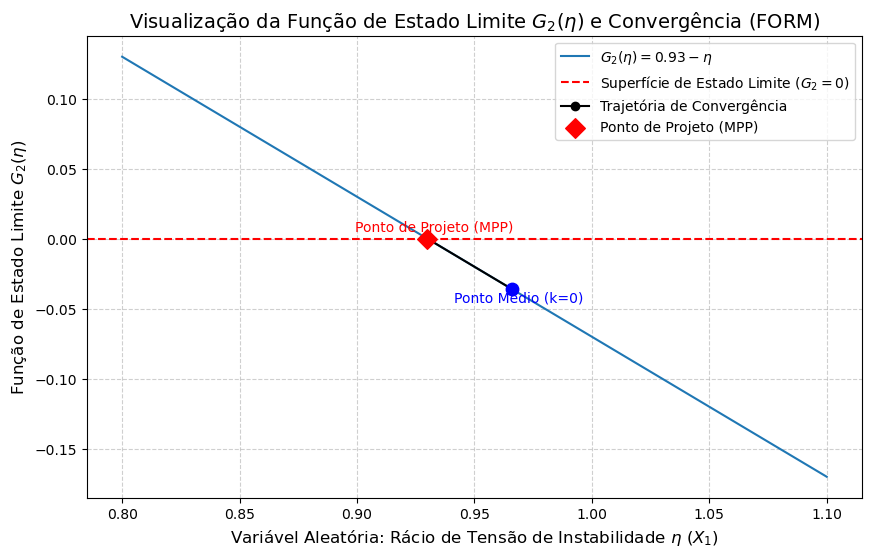

In [14]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

# Equação do estado limite g(X)
X1 = sp.symbols('X1')
vetor_simbolico_x = [X1]
g_sym_function = -X1 + 0.93

def g_fun_numerica(x: np.ndarray) -> float:
    return -x[0] + 0.93 

# Transformação X -> Y da equação de estado-limite g(X)
Y1 = sp.symbols('Y1')
vetor_simbolico_y = [Y1]
def g_y_simbolico_fun (vetor_x_simbolico):
    return  -vetor_x_simbolico[0] + 0.93   

# Descrição das variáveis aleatórias 
X1 = variavel_aleatoria(distribuicao='normal', nome='Indices_vazio', simbolo='X1')
X1.conjunto_parametros(0.966, 0.113) 

vetor_va = [X1]

# Montagem das matrizes de observações e correlações
matriz_dummy_obs = np.zeros((1, 1)) # Matriz das observações para iniciar o algoritmo

Rx_entrada = np.array([
    [1.0],
])

# 4. Inicializar VX (T3)
vx_obj = vetores_variavel_aleatoria(matriz_dummy_obs, vetor_va)
vx_obj.matriz_correlacao_x = Rx_entrada
Rz = vx_obj.matriz_correlacao_nataf() # Garante que Cz é calculado (Cz = Rx = I)
J_yz, J_zy = vx_obj.decomposicao_cholesky()

# Ponto inicial (ponto médio)
x_start = np.array([0.966])
ponto_projeto_obj = Ponto_projeto_HRLF(vx_obj, g_fun_numerica, vetor_simbolico_y, g_y_simbolico_fun, g_sym_function, vetor_simbolico_x, x_start, max_iter=200)

# Resultado da iteração
resultado_iteração = ponto_projeto_obj.execution()
dados_arredondados = [[np.round(x, 3) for x in linha] for linha in resultado_iteração]

# Montagem da tabela
tabela = pd.DataFrame(dados_arredondados, columns=['k', 'y_k', 'B', 'g(x)', 'grad_g(x)', '||grad_g(x)||', 'g(y)', 'x_k' ])

# Extração da coordenada X1 (eta)
coluna_vetor_x = tabela['x_k'] 
X1_coords = coluna_vetor_x.apply(lambda vec: vec[0]) # X1_coords é uma Series de shape (2,)

# --- 2. CÁLCULO CORRIGIDO DE G_COORDS ---
# G_coords deve ser uma Series de shape (2,)

# O cálculo G_coords é simplesmente a aplicação da função G2(eta) = 0.93 - eta
G_coords = 0.93 - X1_coords

# --- 3. PLOTAGEM 1D (G2 vs X1) ---

# Dominio a ser aplicado à g(X)
X1_min = 0.8
X1_max = 1.1 
num_points = 100
X1_plot = np.linspace(X1_min, X1_max, num_points)

# Calculo de g(X) para o plot
G_values_plot = 0.93 - X1_plot

# Inicia a figura
plt.figure(figsize=(10, 6))

# Plot da função G2(eta)
plt.plot(X1_plot, G_values_plot, label='$G_2(\\eta) = 0.93 - \\eta$', color='tab:blue')

# Linha de Estado Limite (G2 = 0)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Superfície de Estado Limite ($G_2 = 0$)')

# Trajetória de convergência (Pontos das iterações)
# Correção: Agora X1_coords e G_coords têm as mesmas dimensões
plt.plot(X1_coords, G_coords, marker='o', linestyle='-', color='black', label='Trajetória de Convergência')

# Marca o Ponto Médio (k=0)
plt.scatter(X1_coords.iloc[0], G_coords.iloc[0], color='blue', marker='o', s=80, zorder=5)
plt.annotate('Ponto Médio (k=0)', (X1_coords.iloc[0], G_coords.iloc[0]), textcoords="offset points", xytext=(5, -10), ha='center', color='blue')

# Marca o Ponto de Projeto (k=1)
plt.scatter(X1_coords.iloc[-1], G_coords.iloc[-1], color='red', marker='D', s=100, zorder=5, label='Ponto de Projeto (MPP)')
plt.annotate('Ponto de Projeto (MPP)', (X1_coords.iloc[-1], G_coords.iloc[-1]), textcoords="offset points", xytext=(5, 5), ha='center', color='red')

# Rótulos e Título
plt.xlabel('Variável Aleatória: Rácio de Tensão de Instabilidade $\\eta$ ($X_1$)', fontsize=12)
plt.ylabel('Função de Estado Limite $G_2(\\eta)$', fontsize=12)
plt.title('Visualização da Função de Estado Limite $G_2(\\eta)$ e Convergência (FORM)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')

# Salva o gráfico
plt.savefig('G2_FORM_Convergence_Plot_1D.png')
print("Gráfico de convergência FORM para G2 salvo como 'G2_FORM_Convergence_Plot_1D.png'")




'''
# Pega os valores de x_k
coluna_vetor_x = tabela['x_k']
X1_coords = coluna_vetor_x.apply(lambda vec: vec[0]) # Pega a 1ª componente (razão q/p')

# Dominio a ser aplicado à g(X)
X1_min = 0.5
X1_max = 1.5
num_points = 100
X1_plot = np.linspace(X1_min, X1_max, num_points)

# Calculo de g(X) para o plot
G_values_plot = g_fun_numerica(X1_plot.reshape(1, num_points))

# Inicia a figura
plt.figure()
plt.plot(X1_plot, G_values_plot, label='$G_2(\\eta) = 0.93 - \\eta$', color='tab:blue')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Superfície de Estado Limite ($G_2=0$)')

# Trajetória de convergência (Pontos das iterações)
# Calcula os valores G2 para os pontos de iteração
G_coords = g_fun_numerica(X1_coords)

# Plota os pontos
plt.plot(X1_coords, G_coords, marker='o', linestyle='-', color='black', label='Trajetória de Convergência')

# Marca o Ponto Médio (k=0)
plt.scatter(X1_coords.iloc[0], G_coords[0], color='blue', marker='o', s=80, zorder=5)
plt.annotate('Ponto Médio (k=0)', (X1_coords.iloc[0], G_coords[0]), textcoords="offset points", xytext=(5, -10), ha='center', color='blue')

# Marca o Ponto de Projeto (k=1)
plt.scatter(X1_coords.iloc[-1], G_coords[-1], color='red', marker='D', s=100, zorder=5, label='Ponto de Projeto (MPP)')
plt.annotate('Ponto de Projeto (MPP)', (X1_coords.iloc[-1], G_coords[-1]), textcoords="offset points", xytext=(5, 5), ha='center', color='red')

# Rótulos e Título
plt.xlabel('Variável Aleatória: Rácio de Tensão de Instabilidade $\\eta$ ($X_1$)', fontsize=12)
plt.ylabel('Função de Estado Limite $G_2(\\eta)$', fontsize=12)
plt.title('Visualização da Função de Estado Limite $G_2(\\eta)$ e Convergência (FORM)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
'''

'''
#Plot
# Vetor com os valores de das variáveis
coluna_vetor_x = tabela['x_k'] 

# Separação de X1 e X2
X1_coords = coluna_vetor_x.apply(lambda vec: vec[0]) # Pega a 1ª componente (razão q/p')

# Dominio a ser aplicado à g(X)
X1_min = 0.5
X1_max = 1.5
X2_min = 100.06
X2_max = 1134.44

# Cria uma grade (mesh) de 100x100 pontos para X1 e X2
num_points = 100
X1_grid = np.linspace(X1_min, X1_max, num_points)
X2_grid = np.linspace(X2_min, X2_max, num_points)
X_mesh_1, X_mesh_2 = np.meshgrid(X1_grid, X2_grid)

# Calculo de g(X)
G_values = np.zeros(X_mesh_1.shape)
for i in range(num_points):
    for j in range(num_points):
        x_point = np.array([X_mesh_1[i, j], X_mesh_2[i, j]])
        G_values[i, j] = g_fun_numerica(x_point)

# Contorno dos valores possíveis
plt.plot([X1_min, X1_max, X1_max, X1_min, X1_min], 
         [X2_min, X2_min, X2_max, X2_max, X2_min], 
         color='gray', linestyle='-', linewidth=1)

# Plot de g(X)
plt.contour(X_mesh_1, X_mesh_2, G_values, levels=[0], colors='gray', linestyles='-', linewidths=2, label='g(X)=0')

# Trajetória de convergência
plt.plot(X1_coords, X2_coords, marker='o',linestyle='', color='tab:blue')
plt.scatter(X1_coords.iloc[-1], X2_coords.iloc[-1], color='red', marker='o')

# Anotações dos pontos
for k, (x1, x2) in enumerate(zip(X1_coords, X2_coords)):
    plt.annotate(str(k), (x1, x2), textcoords="offset points", xytext=(5,5), ha='center')

# Ajusta os limites do eixo para cobrir o domínio e um pouco mais
plt.xlim(X1_min - 0.1*(X1_max-X1_min), X1_max + 0.1*(X1_max-X1_min))
plt.ylim(X2_min - 0.1*(X2_max-X2_min), X2_max + 0.1*(X2_max-X2_min))

plt.xlabel('Void ratio')
plt.ylabel('Mean effective stress')
plt.legend()
plt.show()

tabela
'''
tabela

No código abaixo, a busca pelo ponto $y_{k+1}$ é realizada utilizando a implementação do algoritmo *iHLRF* 

In [ ]:
import numpy as np
import scipy as sc
import sympy as sp
from sympy.utilities.lambdify import lambdify
from typing import Callable, List, Tuple

class Ponto_projeto:
    def __init__(self, vx_obj, g_fun_numerica_x, vetor_simbolico_y, g_y_simbolico, g_sym_fun, vetor_simbolico, x_inicial, max_iter=100):

        # Inicialização das variáveis
        self.vx_obj = vx_obj 
        self.g_fun_x_num = g_fun_numerica_x
        self.vetor_simbolico_y = vetor_simbolico_y
        self.g_y_simbolico = g_y_simbolico
        self.grad_g_x_fun = self.calcular_gradiente_simbolico_x(g_sym_fun, vetor_simbolico)
        self.x_estrela_atual = x_inicial
        self.max_iter = max_iter
        self.historico = []

    # Atualização das matrizes de média e desvio padrão equivalente
    def normal_equivalente_no_ponto (self, vetor_x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

        mu_neq_lista = []
        sigma_neq_lista = []

        for i, va in enumerate(self.vx_obj.vetor_va_cust):
            x_i = vetor_x[i]

            cdf_xi = va.CDF(x_i)
            pdf_xi = va.PDF(x_i)

            z_i = sc.stats.norm.ppf(cdf_xi)
            phi_zi = sc.stats.norm.pdf(z_i)

            sigma_neq_i = phi_zi / pdf_xi
            mu_neq_i = x_i - (z_i * sigma_neq_i)

            mu_neq_lista.append(mu_neq_i)
            sigma_neq_lista.append(sigma_neq_i)

        return np.array(mu_neq_lista), np.diag(sigma_neq_lista)
    
    # Calculo do gradiente numérico da função g(x) a partir da função simbólica fornecida paara g(x)
    def calcular_gradiente_simbolico_x(self, g_sym:sp.Expr, vetor_simbolico: List[sp.Symbol]) -> Callable:
        
        grad_g_sym = [sp.diff(g_sym, x_i) for x_i in vetor_simbolico]

        grad_g_numeric = lambdify(vetor_simbolico, grad_g_sym, 'numpy')
        
        def grad_g_x_numerico(x_vals: np.ndarray) -> np.ndarray:
            return np.array(grad_g_numeric(*x_vals))
        
        return grad_g_x_numerico
     
    # Estrutura principal de calculo e iteração em busca do ponto de projeto
    def execution (self,):

        historico = [] # Vetor que armazena o histórico de iterações

        for k in range(self.max_iter):
            
            # Ponto de projeto x* para a iteração k
            x_k = self.x_estrela_atual 

            # Atualização das matrizes de média e desvio padrão equivalentes para o ponto x_k
            # Calculo dos Jacobianos da transformação X -> Z
            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            vetor_simbolico_y = self.vetor_simbolico_y
            vetor_simbolico_x_calc = (J_xy @ vetor_simbolico_y) + mu_neq
            g_y_simbolico = self.g_y_simbolico(vetor_simbolico_x_calc)
            g_y_numerico = lambdify(vetor_simbolico_y, g_y_simbolico, 'numpy')
            
            def calculo_g_y(vetor_y):
                return g_y_numerico(*vetor_y)
            
            # Trandformação do ponto xk -> yk
            y_k = J_yx @ (x_k - mu_neq)

            # Calculo do índice de confiabilidade para o ponto yk
            beta_k = np.linalg.norm(y_k)
            
            # Avaliação das funções g(x) em x_k e g(y) em y_k
            g_x = self.g_fun_x_num(x_k)
            g_y = calculo_g_y(y_k)

            if k == 0:
                g_y_zero = g_y

            # Calculo do gradiente de g(x) no espaço de projeto X em x_k
            grad_g_x = self.grad_g_x_fun(x_k)

            # Calculo do gradiente de g(y) em y_k a partir da transformação X -> Y
            grad_g_y = (J_xy.T) @ grad_g_x

            # Calculo dos coeficientes de sensibilidade
            alpha = grad_g_y / np.linalg.norm(grad_g_y)

            historico.append([
                k, 
                y_k, 
                beta_k, 
                g_x, 
                grad_g_y, 
                np.linalg.norm(grad_g_y),
                g_y
            ])  

            gamma = 2.0 
            
            # Direção de Busca d_k 
            d_k = (((1 / (np.linalg.norm(grad_g_y)**2)) * ((grad_g_y.T @ y_k) - g_y)) * grad_g_y) - y_k
            
            if np.abs(g_y) >= np.abs(1e-3 * g_y_zero):
            
                func_1 = np.linalg.norm(y_k) / np.linalg.norm(grad_g_y)
                func_2 = (0.5 * (np.linalg.norm(y_k + d_k)**2)) / np.abs(g_y)
                c_k = gamma * np.maximum(func_1, func_2)
            else:
                c_k = gamma * np.linalg.norm(y_k) / np.linalg.norm(grad_g_y)

                #Busca Linear 
            def m(y_vec, g_y_val=None):
                if g_y_val is None:
                    g_y_val = calculo_g_y(y_vec)
                return 0.5 * (np.linalg.norm(y_vec)**2) + (c_k * np.abs(g_y_val))

            # gradiente do mérito no ponto y_k
            sign_g = np.sign(g_y) if g_y != 0 else 1.0
            grad_m_y_k = y_k + (c_k * grad_g_y * sign_g)

            # Armijo
            lambda_k = 1.0
            rho = 0.5 #b
            sigma = 0.1 #a
            backtracks = 0
            m_y = m(y_k, g_y)
            grad_m_dot_d = float(grad_m_y_k.T @ d_k)

            while backtracks < 50:
                y_trial = y_k + lambda_k * d_k
                g_y_trial = calculo_g_y(y_trial)
                m_trial = m(y_trial, g_y_trial)
                rhs = m_y + sigma * lambda_k * grad_m_dot_d

                if m_trial <= rhs:
                    break
                
                lambda_k *= rho
                backtracks += 1

            #Atualização do Ponto
            y_k_mais_1 = y_k + lambda_k * d_k
                
            # Calculo do ponto x_k+1 a partir da tranformação Y -> X
            x_k_mais_1 = (J_xy @ y_k_mais_1) + mu_neq

            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k_mais_1)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            vetor_simbolico_y = self.vetor_simbolico_y
            vetor_simbolico_x_calc = (J_xy @ vetor_simbolico_y) + mu_neq
            g_y_simbolico = self.g_y_simbolico(vetor_simbolico_x_calc)
            g_y_numerico = lambdify(vetor_simbolico_y, g_y_simbolico, 'numpy')
            def calculo_g_y(vetor_y):
                return g_y_numerico(*vetor_y)

            # Verificação da convergência do ponto y_k+1
            ep = 1e-3    
            g_x_mais_1 = self.g_fun_x_num(x_k_mais_1)
            grad_x_mais_1 = self.grad_g_x_fun(x_k_mais_1)

            g_y_mais_1 = calculo_g_y(y_k_mais_1)
            grad_y_mais_1 = (J_xy.T) @ grad_x_mais_1

            alpha_mais_1 = grad_y_mais_1 / np.linalg.norm(grad_y_mais_1)

            verificador = 1 - (abs((grad_y_mais_1.T @ y_k_mais_1) / ((np.linalg.norm(grad_y_mais_1)) * (np.linalg.norm(y_k_mais_1)))))
            
            if verificador < ep:
                if abs(g_y_mais_1) < abs (ep * g_y_zero):

                    historico.append([
                        k+1, 
                        y_k_mais_1, 
                        np.linalg.norm(y_k_mais_1), 
                        g_x_mais_1, 
                        grad_y_mais_1, 
                        np.linalg.norm(grad_y_mais_1),
                        g_y_mais_1
                    ])  

                    break
                else:
                    self.x_estrela_atual = x_k_mais_1 
            else:
                self.x_estrela_atual = x_k_mais_1

                if k == self.max_iter - 1:
                    print(f"Não convergiu em {self.max_iter} iterações")
    
        return historico
    

Para a resolução do problema vamos utilizar o algoritmo abaixo com o método de busca sendo o *iHRLF*.

In [34]:
import numpy as np
import scipy as sc
import sympy as sp
from sympy.utilities.lambdify import lambdify
from typing import Callable, List, Tuple

class Ponto_projeto_iHRLF:
    def __init__(self, vx_obj, g_fun_numerica_x, vetor_simbolico_y, g_y_simbolico, g_sym_fun, vetor_simbolico, x_inicial, max_iter=100):

        # Inicialização das variáveis
        self.vx_obj = vx_obj 
        self.g_fun_x_num = g_fun_numerica_x
        self.vetor_simbolico_y = vetor_simbolico_y
        self.g_y_simbolico = g_y_simbolico
        self.grad_g_x_fun = self.calcular_gradiente_simbolico_x(g_sym_fun, vetor_simbolico)
        self.x_estrela_atual = x_inicial
        self.max_iter = max_iter
        self.historico = []

    # Atualização das matrizes de média e desvio padrão equivalente
    def normal_equivalente_no_ponto (self, vetor_x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

        mu_neq_lista = []
        sigma_neq_lista = []

        for i, va in enumerate(self.vx_obj.vetor_va_cust):
            x_i = vetor_x[i]

            cdf_xi = va.CDF(x_i)
            pdf_xi = va.PDF(x_i)

            z_i = sc.stats.norm.ppf(cdf_xi)
            phi_zi = sc.stats.norm.pdf(z_i)

            sigma_neq_i = phi_zi / pdf_xi
            mu_neq_i = x_i - (z_i * sigma_neq_i)

            mu_neq_lista.append(mu_neq_i)
            sigma_neq_lista.append(sigma_neq_i)

        return np.array(mu_neq_lista), np.diag(sigma_neq_lista)
    
    # Calculo do gradiente numérico da função g(x) a partir da função simbólica fornecida paara g(x)
    def calcular_gradiente_simbolico_x(self, g_sym:sp.Expr, vetor_simbolico: List[sp.Symbol]) -> Callable:
        
        grad_g_sym = [sp.diff(g_sym, x_i) for x_i in vetor_simbolico]

        grad_g_numeric = lambdify(vetor_simbolico, grad_g_sym, 'numpy')
        
        def grad_g_x_numerico(x_vals: np.ndarray) -> np.ndarray:
            return np.array(grad_g_numeric(*x_vals))
        
        return grad_g_x_numerico
     
    # Estrutura principal de calculo e iteração em busca do ponto de projeto
    def execution (self,):

        historico = [] # Vetor que armazena o histórico de iterações

        for k in range(self.max_iter):
            
            # Ponto de projeto x* para a iteração k
            x_k = self.x_estrela_atual 

            # Atualização das matrizes de média e desvio padrão equivalentes para o ponto x_k
            # Calculo dos Jacobianos da transformação X -> Z
            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            vetor_simbolico_y = self.vetor_simbolico_y
            vetor_simbolico_x_calc = (J_xy @ vetor_simbolico_y) + mu_neq
            g_y_simbolico = self.g_y_simbolico(vetor_simbolico_x_calc)
            g_y_numerico = lambdify(vetor_simbolico_y, g_y_simbolico, 'numpy')
            
            def calculo_g_y(vetor_y):
                return g_y_numerico(*vetor_y)
            
            # Trandformação do ponto xk -> yk
            y_k = J_yx @ (x_k - mu_neq)

            # Calculo do índice de confiabilidade para o ponto yk
            beta_k = np.linalg.norm(y_k)
            
            # Avaliação das funções g(x) em x_k e g(y) em y_k
            g_x = self.g_fun_x_num(x_k)
            g_y = calculo_g_y(y_k)

            if k == 0:
                g_y_zero = g_y

            # Calculo do gradiente de g(x) no espaço de projeto X em x_k
            grad_g_x = self.grad_g_x_fun(x_k)

            # Calculo do gradiente de g(y) em y_k a partir da transformação X -> Y
            grad_g_y = (J_xy.T) @ grad_g_x

            # Calculo dos coeficientes de sensibilidade
            alpha = grad_g_y / np.linalg.norm(grad_g_y)

            historico.append([
                k, 
                y_k, 
                beta_k, 
                g_x, 
                grad_g_y, 
                np.linalg.norm(grad_g_y),
                g_y,
                x_k
            ])  

            gamma = 2.0 
            
            # Direção de Busca d_k 
            d_k = (((1 / (np.linalg.norm(grad_g_y)**2)) * ((grad_g_y.T @ y_k) - g_y)) * grad_g_y) - y_k
            
            if np.abs(g_y) >= np.abs(1e-3 * g_y_zero):
            
                func_1 = np.linalg.norm(y_k) / np.linalg.norm(grad_g_y)
                func_2 = (0.5 * (np.linalg.norm(y_k + d_k)**2)) / np.abs(g_y)
                c_k = gamma * np.maximum(func_1, func_2)
            else:
                c_k = gamma * np.linalg.norm(y_k) / np.linalg.norm(grad_g_y)

                #Busca Linear 
            def m(y_vec, g_y_val=None):
                if g_y_val is None:
                    g_y_val = calculo_g_y(y_vec)
                return 0.5 * (np.linalg.norm(y_vec)**2) + (c_k * np.abs(g_y_val))

            # gradiente do mérito no ponto y_k
            sign_g = np.sign(g_y) if g_y != 0 else 1.0
            grad_m_y_k = y_k + (c_k * grad_g_y * sign_g)

            # Armijo
            lambda_k = 1.0
            rho = 0.5 #b
            sigma = 0.1 #a
            backtracks = 0
            m_y = m(y_k, g_y)
            grad_m_dot_d = float(grad_m_y_k.T @ d_k)

            while backtracks < 50:
                y_trial = y_k + lambda_k * d_k
                g_y_trial = calculo_g_y(y_trial)
                m_trial = m(y_trial, g_y_trial)
                rhs = m_y + sigma * lambda_k * grad_m_dot_d

                if m_trial <= rhs:
                    break
                
                lambda_k *= rho
                backtracks += 1

            #Atualização do Ponto
            y_k_mais_1 = y_k + lambda_k * d_k
                
            # Calculo do ponto x_k+1 a partir da tranformação Y -> X
            x_k_mais_1 = (J_xy @ y_k_mais_1) + mu_neq

            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k_mais_1)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            vetor_simbolico_y = self.vetor_simbolico_y
            vetor_simbolico_x_calc = (J_xy @ vetor_simbolico_y) + mu_neq
            g_y_simbolico = self.g_y_simbolico(vetor_simbolico_x_calc)
            g_y_numerico = lambdify(vetor_simbolico_y, g_y_simbolico, 'numpy')
            def calculo_g_y(vetor_y):
                return g_y_numerico(*vetor_y)

            # Verificação da convergência do ponto y_k+1
            ep = 1e-3    
            g_x_mais_1 = self.g_fun_x_num(x_k_mais_1)
            grad_x_mais_1 = self.grad_g_x_fun(x_k_mais_1)

            g_y_mais_1 = calculo_g_y(y_k_mais_1)
            grad_y_mais_1 = (J_xy.T) @ grad_x_mais_1

            alpha_mais_1 = grad_y_mais_1 / np.linalg.norm(grad_y_mais_1)

            verificador = 1 - (abs((grad_y_mais_1.T @ y_k_mais_1) / ((np.linalg.norm(grad_y_mais_1)) * (np.linalg.norm(y_k_mais_1)))))
            
            if verificador < ep:
                if abs(g_y_mais_1) < abs (ep * g_y_zero):

                    historico.append([
                        k+1, 
                        y_k_mais_1, 
                        np.linalg.norm(y_k_mais_1), 
                        g_x_mais_1, 
                        grad_y_mais_1, 
                        np.linalg.norm(grad_y_mais_1),
                        g_y_mais_1,
                        x_k_mais_1
                    ])  

                    break
                else:
                    self.x_estrela_atual = x_k_mais_1 
            else:
                self.x_estrela_atual = x_k_mais_1

                if k == self.max_iter - 1:
                    print(f"Não convergiu em {self.max_iter} iterações")
    
        return historico

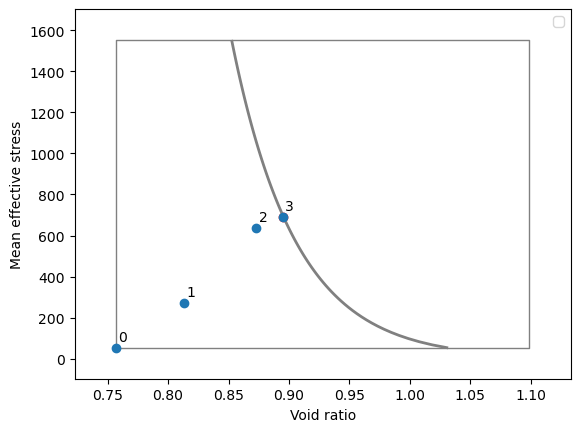

,k,y_k,B,g(x),grad_g(x),||grad_g(x)||,g(y),x_k
0,0,"[-0.508, -0.997]",1.119,0.275,"[-0.071, -0.532]",0.536,0.275,"[0.757, 52.831]"
1,1,"[-0.1, -0.538]",0.548,0.132,"[-0.077, -0.151]",0.169,0.132,"[0.813, 271.2]"
2,2,"[0.089, 0.23]",0.247,0.026,"[-0.082, -0.101]",0.131,0.026,"[0.873, 637.453]"
3,3,"[0.275, 0.338]",0.436,0.000,"[-0.085, -0.1]",0.131,-0.000,"[0.895, 688.894]"


In [36]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

# Equação do estado limite g(X)
X1,X2 = sp.symbols('X1 X2')
vetor_simbolico_x = [X1, X2]
g_sym_function = -X1 + (1.242 - (0.053 * sp.log(X2))) - 0.00

def g_fun_numerica(x: np.ndarray) -> float:
    return -x[0] + (1.242 - (0.053 * np.log(x[1]))) - 0.00

# Transformação X -> Y da equação de estado-limite g(X)
Y1,Y2 = sp.symbols('Y1 Y2')
vetor_simbolico_y = [Y1, Y2]
def g_y_simbolico_fun (vetor_x_simbolico):
    return  -vetor_x_simbolico[0] + (1.242 - (0.053 * sp.log(vetor_x_simbolico[1]))) - 0.00            

# Descrição das variáveis aleatórias 
X1 = variavel_aleatoria(distribuicao='lognormal', nome='Indices_vazio', simbolo='X1')
X1.calculo_parametros(0.856, 0.081) 

X2 = variavel_aleatoria(distribuicao='normal', nome='Mean_effective_stess', simbolo='X2')
X2.conjunto_parametros(527.822, 381.481) 

vetor_va = [X1, X2]

# Montagem das matrizes de observações e correlações
matriz_dummy_obs = np.zeros((2, 2)) # Matriz das observações para iniciar o algoritmo

Rx_entrada = np.array([
    [1.0, -0.598],
    [-0.598, 1.0],
])

# 4. Inicializar VX (T3)
vx_obj = vetores_variavel_aleatoria(matriz_dummy_obs, vetor_va)
vx_obj.matriz_correlacao_x = Rx_entrada
Rz = vx_obj.matriz_correlacao_nataf() # Garante que Cz é calculado (Cz = Rx = I)
J_yz, J_zy = vx_obj.decomposicao_cholesky()

# Ponto inicial (ponto médio)
x_start = np.array([0.757, 52.831])
ponto_projeto_obj = Ponto_projeto_iHRLF(vx_obj, g_fun_numerica, vetor_simbolico_y, g_y_simbolico_fun, g_sym_function, vetor_simbolico_x, x_start, max_iter=200)

# Resultado da iteração
resultado_iteração = ponto_projeto_obj.execution()
dados_arredondados = [[np.round(x, 3) for x in linha] for linha in resultado_iteração]

# Montagem da tabela
tabela = pd.DataFrame(dados_arredondados, columns=['k', 'y_k', 'B', 'g(x)', 'grad_g(x)', '||grad_g(x)||', 'g(y)', 'x_k' ])

#Plot
# Vetor com os valores de das variáveis
coluna_vetor_x = tabela['x_k'] 

# Separação de X1 e X2
X1_coords = coluna_vetor_x.apply(lambda vec: vec[0]) # Pega a 1ª componente (Indice de vazios)
X2_coords = coluna_vetor_x.apply(lambda vec: vec[1]) # Pega a 2ª componente (Tensão efetiva média)

# Dominio a ser aplicado à g(X)
X1_min = 0.757
X1_max = 1.099 
X2_min = 52.831
X2_max = 1552.410 

# Cria uma grade (mesh) de 100x100 pontos para X1 e X2
num_points = 100
X1_grid = np.linspace(X1_min, X1_max, num_points)
X2_grid = np.linspace(X2_min, X2_max, num_points)
X_mesh_1, X_mesh_2 = np.meshgrid(X1_grid, X2_grid)

# Calculo de g(X)
G_values = np.zeros(X_mesh_1.shape)
for i in range(num_points):
    for j in range(num_points):
        x_point = np.array([X_mesh_1[i, j], X_mesh_2[i, j]])
        G_values[i, j] = g_fun_numerica(x_point)

# Contorno dos valores possíveis
plt.plot([X1_min, X1_max, X1_max, X1_min, X1_min], 
         [X2_min, X2_min, X2_max, X2_max, X2_min], 
         color='gray', linestyle='-', linewidth=1)

# Plot de g(X)
plt.contour(X_mesh_1, X_mesh_2, G_values, levels=[0], colors='gray', linestyles='-', linewidths=2, label='g(X)=0')

# Trajetória de convergência
plt.plot(X1_coords, X2_coords, marker='o',linestyle='', color='tab:blue')
plt.scatter(X1_coords.iloc[-1], X2_coords.iloc[-1], color='red', marker='o')

# Anotações dos pontos
for k, (x1, x2) in enumerate(zip(X1_coords, X2_coords)):
    plt.annotate(str(k), (x1, x2), textcoords="offset points", xytext=(5,5), ha='center')

# Ajusta os limites do eixo para cobrir o domínio e um pouco mais
plt.xlim(X1_min - 0.1*(X1_max-X1_min), X1_max + 0.1*(X1_max-X1_min))
plt.ylim(X2_min - 0.1*(X2_max-X2_min), X2_max + 0.1*(X2_max-X2_min))

plt.xlabel('Void ratio')
plt.ylabel('Mean effective stress')
plt.legend()
plt.show()
tabela